In [24]:
# GPU device info

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [25]:
# connect google drive to google collab

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Import Necessary Libraries

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19
import cv2
import os
import random
from keras.preprocessing import image

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Data Understanding

In [27]:
# flower class labels
labels = ['dandelion', 'daisy','tulip','sunflower','rose']

img_size = 128
# function to load data from certain path
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [28]:
# load data from given path using get_data function
data = get_data("/content/gdrive/MyDrive/Colab Notebooks/Flower Classification/Train")

In [29]:
print(os.listdir("/content/gdrive/MyDrive/Colab Notebooks/Flower Classification/Test"))

['sunflower.jpg', '.ipynb_checkpoints', 'dandelion.jpg', 'daisy.jpg', 'tulip.jpg', 'rose.jpg', 'rose2.jpg']


###### images count in each column

In [30]:
len(os.listdir('gdrive/MyDrive/Colab Notebooks/Flower Classification/Train/daisy'))

773

In [31]:
len(os.listdir('gdrive/MyDrive/Colab Notebooks/Flower Classification/Train/dandelion'))

1051

In [32]:
len(os.listdir('gdrive/MyDrive/Colab Notebooks/Flower Classification/Train/rose'))

783

In [33]:
len(os.listdir('gdrive/MyDrive/Colab Notebooks/Flower Classification/Train/tulip'))

983

In [34]:
len(os.listdir('gdrive/MyDrive/Colab Notebooks/Flower Classification/Train/sunflower'))

732

# 3. Data Visualization

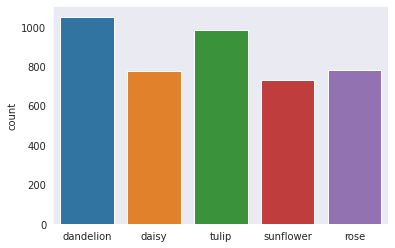

In [35]:
# bar graph 
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(x=l)
plt.show()
del l

###### Above diagram shows the number of data in each classes. Dandelion has the highest count of data while sunflower has the lowest data count.

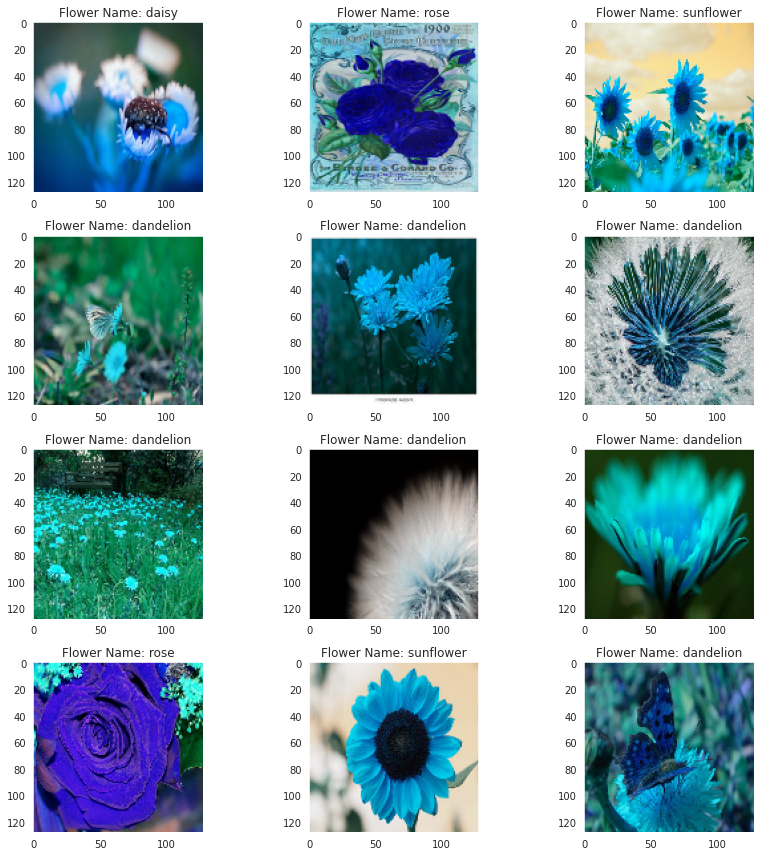

In [36]:
# image plot from at least one of each class

fig,ax=plt.subplots(4, 3)
fig.set_size_inches(12,12)
for i in range(4):
    for j in range (3):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower Name: '+labels[data[l][1]])
        
plt.tight_layout()

In [37]:
# data seperation for train and validation
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [38]:
# Normalize the data
x = np.array(x) / 255

In [39]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

###### Note: Label Binarizer is an SciKit Learn class that accepts Categorical data as input and returns an Numpy array.

In [40]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [41]:
# train test model
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)

In [42]:
del x,y

# 4. Training the model

###### VGG-19 is a 19-layer deep convolutional neural network. VGG-19 is a 19-layer deep convolutional neural network that you may load. You may use the ImageNet database [1], which has been trained on over a million photographs, to import a pretrained version of the network. The network was pre-trained to sort photographs into 1000 distinct categories. 
In the large majority of instances, Adam is the finest adaptive optimization approach. The adaptive learning rate is appropriate for sparse data. Adam is a method for dealing with sparse gradients in noisy environments that combines the best features of the AdaGrad and RMSProp algorithms.
Binary crossentropy is for binary class classification dataset while categorical crossentropy is for multiclass classification dataset. Since we have multiple classes i.e., 5 classes, we had to choose categorical crossentropy over binary crossentropy.

In [43]:
pre_trained_model = VGG19(input_shape=(128,128,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(5 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()
del pre_trained_model

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,034,629
Trainable params: 4,729,861
Non-trainable params: 15,304,768
_________________________________________________________________


In [44]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.6, min_lr=0.000001)  #When a metric no longer improves, lower the learning rate.

###### Generally, it is better to put the value of epochs over 30 but there was no difference in the accuracy and loss when epochs reached 25. So, we gave 25 number of epochs as further increase in it won’t improve the model by marginal difference.

In [45]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 25 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/25
55/55 [==============================] - 89s 1s/step - loss: 0.9437 - accuracy: 0.6465 - val_loss: 0.9096 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 2/25
55/55 [==============================] - 67s 1s/step - loss: 0.5941 - accuracy: 0.7888 - val_loss: 0.6026 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 3/25
55/55 [==============================] - 67s 1s/step - loss: 0.3322 - accuracy: 0.8846 - val_loss: 0.5147 - val_accuracy: 0.8081 - lr: 0.0010
Epoch 4/25
55/55 [==============================] - 67s 1s/step - loss: 0.2075 - accuracy: 0.9314 - val_loss: 0.6415 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 5/25
55/55 [==============================] - 67s 1s/step - loss: 0.1337 - accuracy: 0.9528 - val_loss: 0.6066 - val_accuracy: 0.8058 - lr: 0.0010
Epoch 6/25
54/55 [============================>.] - ETA: 1s - loss: 0.1110 - accuracy: 0.9653
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
55/55 [==============================] - 67s 1s/step - loss: 0.11

In [46]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

28/28 [==============================] - 15s 363ms/step - loss: 0.7786 - accuracy: 0.8358
Loss of the model is -  0.7785850763320923
28/28 [==============================] - 10s 366ms/step - loss: 0.7786 - accuracy: 0.8358
Accuracy of the model is -  83.58381390571594 %


##### Analysis after Model Training

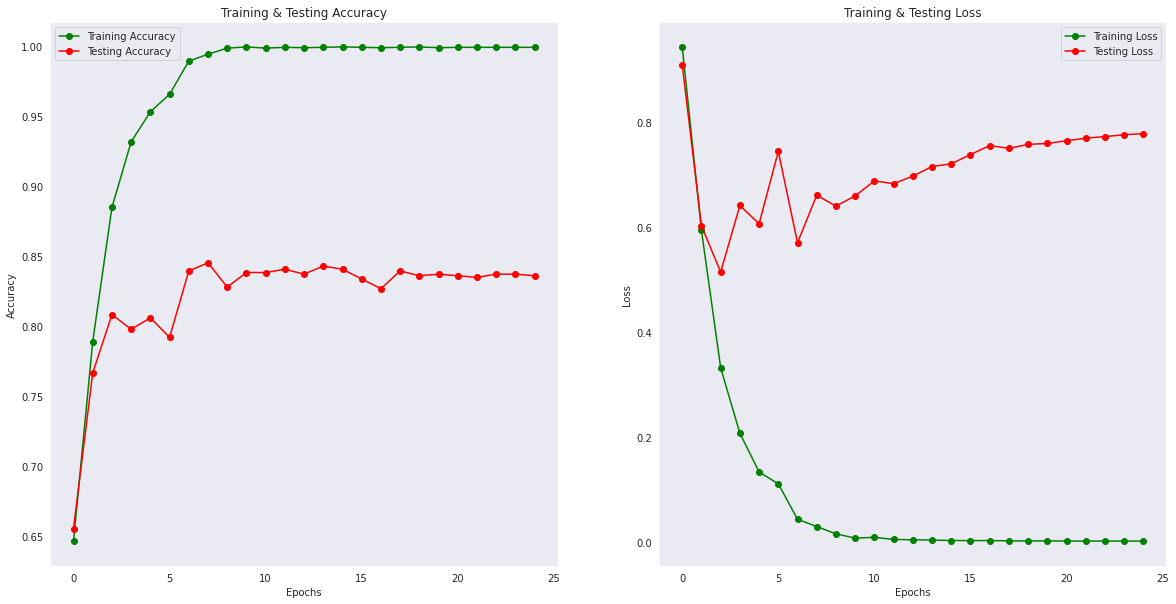

In [47]:
# loss and accuracy figurization

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()
del epochs

For accuracy,
Increse in number of epochs has resulted into increment in training accuracy until at some epoch number. After that epoch number, the accuracy of the training becomes constant. Similarly, increase in epoch count increases testing accuracy but at some epoch count, there seems to be fall in testing accuracy after which again rise in testing accuracy is seen. After certain epoch count, the testing accuracy also seems to be constant.

For loss,
Increse in number of epochs has resulted into decrenebt in training loss until at some epoch number. After that epoch number, the loss of the training becomes constant. Similarly, increase in epoch count increases testing loss but at some epoch count, there seems to be rise in testing loss. After certain epoch count, the testing loss seems to be constant.

# 5. Evaluate the model

In [48]:
predictions = model.predict(x_test)
predictions[:5]

array([[8.9252479e-03, 9.5811760e-01, 2.8064041e-04, 3.2675747e-02,
        7.4549757e-07],
       [9.9999976e-01, 2.1933643e-07, 6.2865007e-09, 9.9869188e-09,
        5.8025218e-08],
       [1.1463533e-02, 7.1026540e-01, 2.5183831e-03, 1.6715027e-02,
        2.5903770e-01],
       [9.5763859e-15, 2.9052899e-13, 2.0588752e-16, 1.0000000e+00,
        1.4546491e-20],
       [7.4150332e-04, 1.5149231e-02, 9.8343188e-01, 2.6805178e-04,
        4.0933731e-04]], dtype=float32)

In [49]:
predictions = label_binarizer.inverse_transform(predictions)

In [50]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [51]:
print(classification_report(y_test_inv, predictions, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.86      0.87      0.87       226
       daisy       0.85      0.83      0.84       183
       tulip       0.83      0.79      0.81       193
   sunflower       0.86      0.88      0.87       123
        rose       0.77      0.82      0.79       140

    accuracy                           0.84       865
   macro avg       0.83      0.84      0.84       865
weighted avg       0.84      0.84      0.84       865



Above is the classification report that shows how well the model has performed for identifying the classes of the flower from validation dataset. There are precision, recall, f1-score for every classes and overall accuracy of the model. The overall accuracy of the model is 0.86 which is 86%. This shows that the model has performed great for identification of classes of flowers. The precision, recall and f1-score are also above 80% for all the flower classes. Among the 5 classes, sunflower has gained higher precision with 91% score, dandelion has gained higher recall with 91% score and higher f1-score with 90% score. 

In [52]:
cm = confusion_matrix(y_test_inv,predictions)
cm

array([[197,  15,   8,   4,   2],
       [ 17, 151,   5,   6,   4],
       [  6,   6, 152,   4,  25],
       [  5,   4,   2, 108,   4],
       [  4,   2,  16,   3, 115]])

In [53]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

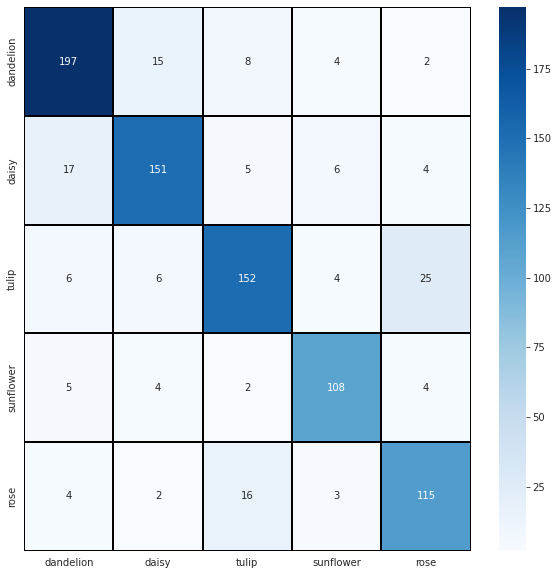

In [61]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)
plt.show()

In above heatmap diagram of flower classification, xlabel is actual data or class of the flower while ylabel is class predicted by the model. So, from above diagram we can know that our model has predicted better result with accuracy more than 85%. This accuracy is considered one of the finest accuracies in model building in CNN. We can see from above figure that model has predicted 199 correct predictions for dandelion, 126 correct predictions for daisy, 166 correct predictions for tulip, 116 correct predictions for sunflower and 133 correct predictions for rose class. Some predictions are predicted in wrong class whose number is very less and count of most of the wrong predictions are less than 10 which makes our model to be good. Incase of rose and tulip prediction there is normally more wrong predictions i.e., above 20 which can be because of similar structure between rose and the tulip flower.

In [55]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==12):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==12):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

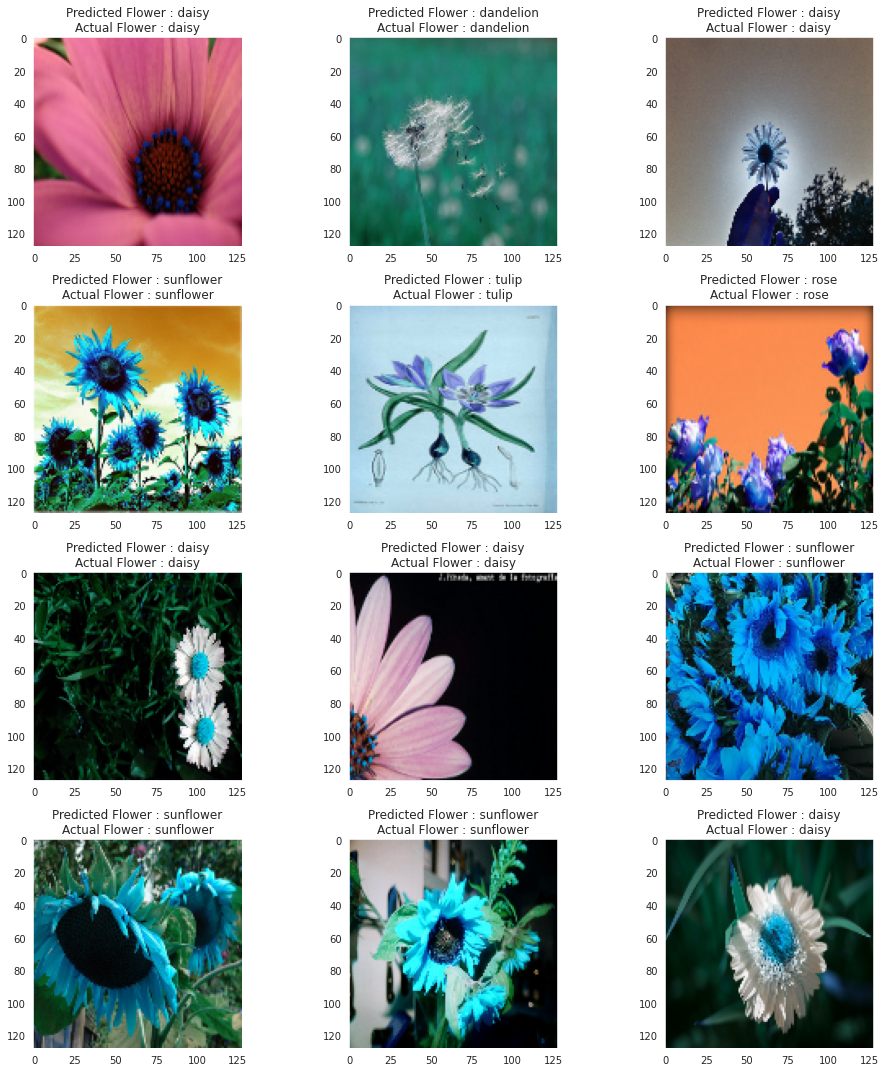

In [56]:
count=0
fig,ax=plt.subplots(4,3)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (3):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

Incorrectly classified flower images

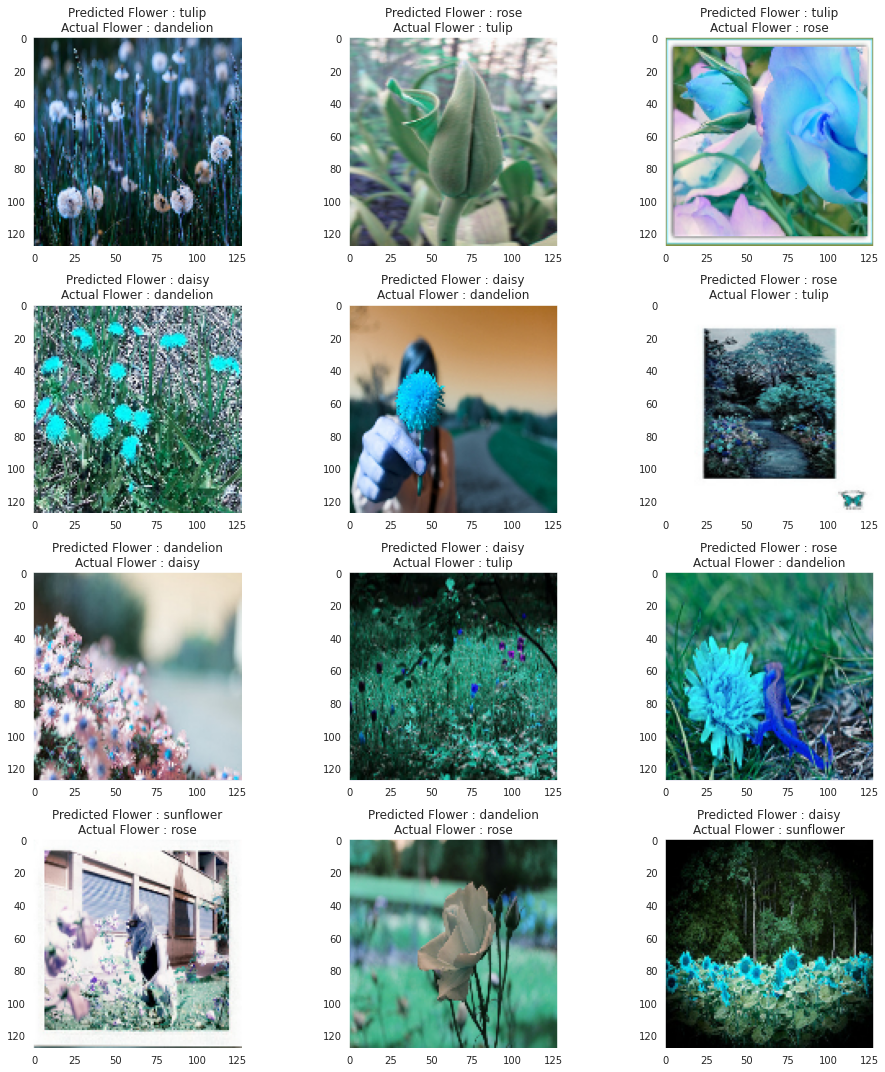

In [57]:
count=0
fig,ax=plt.subplots(4,3)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (3):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

# 6. Results and Predictions

In [58]:
labels

['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']

In [59]:
for i in np.arange(5):
 print(labels[i], i)

dandelion 0
daisy 1
tulip 2
sunflower 3
rose 4



Predicted image: rose



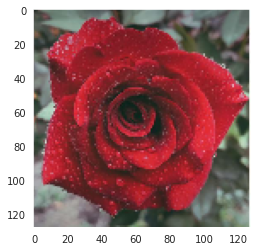

In [60]:
img = image.load_img('/content/gdrive/MyDrive/Colab Notebooks/Flower Classification/Test/rose2.jpg', target_size=(128, 128))
image_test = image.img_to_array(img)
test_img = np.expand_dims(image_test, axis=0)
result = model.predict(test_img)
pred = np.argmax(result) 
plt.imshow(img)

for i in np.arange(5):
  if pred == i:
      print('\nPredicted image: ' + labels[i] + '\n')

Finally testing images from the test folder. Here we randomly put the test images from test folder and predict using the model that we built. And then we conclude the findings and results.